<a href="https://colab.research.google.com/github/aminmotaharinia/ELEC5210_homework/blob/main/ELEC5210_Homework1_version2_TA_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HKUST ELEC5210 Advanced Topics in Nanoelectronics**


This colab notebook provides code and a framework for ***Homework 1***. You can work out your solutions here.

Please fill out this [feedback form](https://google.com) when you finished this homework. We would love to hear your thoughts or feedback on how we can improve this homework!

## Goals

In this homework, you will study both the static and dynamic behavior of magnetization in magnetic tunnel junctions (MTJs). The goals of this assignment are as follows:

- Understand energy minimization and simulate free-layer hysteresis for both in-plane and perpendicular magnetic anisotropies

- Analyze magnetization dynamics under an applied magnetic field, determine the critical switching field, and study how switching speed depends on field strength

- Investigate spin-transfer torque (STT) switching, extract the critical current, and understand the dependence of switching speed on current magnitude

- Explore voltage-controlled magnetic anisotropy (VCMA) switching, determine the critical voltage, and study how switching speed and switching probability depend on voltage amplitude and pulse duration

## Contents

There are two main sections in this homework: ***static magnetic behavior*** and ***dynamic magnetic behavior***.

There are ***10*** questions in total:
- For *static magnetic behavior*, there are ***4*** questions (Question 1-4).
- For *dynamic magnetic behavior*, there are ***6*** questions (Question 5-10).

Parts of this homework requires looking into the following references:

[1]

[2]

[3]

[4]

[5]

# Setup

In [ ]:
# ==============================
# Clone ELEC5210 Homework Repo
# ==============================

!git clone https://github.com/aminmotaharinia/ELEC5210_homework.git
%cd ELEC5210_homework

# ==============================
# Install dependencies
# ==============================
!python -m pip install -q --upgrade pip
!pip install -r requirements.txt

# ==============================
# Make repo importable
# ==============================

import os, sys

# If your code is inside src/ (recommended layout)
if os.path.isdir("src"):
    sys.path.insert(0, os.path.abspath("src"))
else:
    # If modules are at repo root
    sys.path.insert(0, os.path.abspath("."))


print("Setup complete ✅")


Cloning into 'ELEC5210_homework'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 47 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 278.33 KiB | 2.99 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/ELEC5210_homework/ELEC5210_homework
Setup complete ✅


In [ ]:
from initialize import init
from dynamic_switching import switching
from tmr import tmr
import constants
from constants import *
from tqdm import trange
import matplotlib.pyplot as plt


# Question 1
## Let's first observe static behavior of a single domain magnet in 4 different possible scenarios
Single domain magnetic tunnel junctions have been extremely more popular due to their non-volatiliy. Thus, it's important to investigate their behavior when there is no active energy is applied, i.e. static magnetic behavior.
As taught in class, free layer (FL) could either have perpendicular anisotropy axis as the easy axis or in plane anisotopy axis as the easy axis.

## Parameter setup

In [ ]:
# --- Parameters ---
mu0 = 4*np.pi*1e-7
Ms  = 1.0          # normalized
Ku  = 0.5

# Anisotropy field
Hk = 2*Ku/(mu0*Ms)

# Field sweep range
Hmax = 1.5 * Hk
npts = 500

# Decreasing branch: +Hmax → -Hmax
H_down = np.linspace(Hmax, -Hmax, npts)

# Increasing branch: -Hmax → +Hmax
H_up = np.linspace(-Hmax, Hmax, npts)

# --- Magnetization arrays ---
M_down = np.ones_like(H_down) * Ms
M_up   = -np.ones_like(H_up) * Ms

# Apply switching condition
M_down[H_down < -Hk] = -Ms
M_up[H_up > Hk] = Ms

## 🔹 How does a perpendicular magnet respond to an out-of-plane field?
Perpendicular magnetic anisotropy (PMA) plays a central role in modern spin-transfer torque magnetic random-access memory (STT-MRAM). In commercially available STT-MRAM technologies, perpendicular magnetic tunnel junctions (p-MTJs) are used to achieve improved scalability, thermal stability, and lower switching current compared to in-plane designs.

Let us first investigate the static behavior of a free layer with perpendicular magnetic anisotropy under an out-of-plane magnetic field.

System evolution

In [ ]:
M_down[H_down < -Hk] = -Ms
M_up[H_up > Hk] = Ms

Observable extraction (2 points)

In [ ]:
##################### YOUR CODE STARTS HERE #####################
# Observable extraction from hysteresis data

def _zero_crossing_x(x, y):
    """
    Return x where y crosses 0 using linear interpolation between the first
    sign-change pair found in the data order. Returns np.nan if no crossing.
    """
    y = np.asarray(y, dtype=float)
    x = np.asarray(x, dtype=float)

    # exact zero points
    idx0 = np.where(y == 0)[0]
    if idx0.size > 0:
        return float(x[idx0[0]])

    s = np.sign(y)
    s[s == 0] = 1  # treat exact zeros as positive for sign-change detection
    idx = np.where(s[:-1] * s[1:] < 0)[0]
    if idx.size == 0:
        return np.nan

    k = int(idx[0])
    # linear interpolation: y = y0 + (y1 - y0) * a, solve for y=0
    x0, x1 = x[k], x[k + 1]
    y0, y1 = y[k], y[k + 1]
    return float(x0 - y0 * (x1 - x0) / (y1 - y0))


def _value_at_H0(H, M):
    """Return M at H=0 by interpolation (or nearest if outside range)."""
    H = np.asarray(H, dtype=float)
    M = np.asarray(M, dtype=float)

    # exact zero points
    idx0 = np.where(H == 0)[0]
    if idx0.size > 0:
        return float(M[idx0[0]])

    # if H doesn't bracket 0, take nearest
    if (H.min() > 0) or (H.max() < 0):
        return float(M[np.argmin(np.abs(H))])

    # interpolate M(H) at H=0
    order = np.argsort(H)
    return float(np.interp(0.0, H[order], M[order]))


# 1) Coercive fields (where M crosses 0)
Hc_down = _zero_crossing_x(H_down, M_down)  # typically negative
Hc_up   = _zero_crossing_x(H_up,   M_up)    # typically positive

# 2) Remanent magnetization at H=0
Mr_down = _value_at_H0(H_down, M_down)
Mr_up   = _value_at_H0(H_up,   M_up)

# 3) Print clearly (also print normalized versions if Hk and Ms exist)
print("Extracted hysteresis observables:")
print(f"  Hc (decreasing branch) = {Hc_down:.6g}")
print(f"  Hc (increasing branch) = {Hc_up:.6g}")
print(f"  Mr (decreasing branch) = {Mr_down:.6g}")
print(f"  Mr (increasing branch) = {Mr_up:.6g}")

# Optional: normalized outputs (only if Hk and Ms are defined)
try:
    print("\nNormalized (using Hk and Ms):")
    print(f"  Hc_down / Hk = {Hc_down / Hk:.6g}")
    print(f"  Hc_up   / Hk = {Hc_up   / Hk:.6g}")
    print(f"  Mr_down / Ms = {Mr_down / Ms:.6g}")
    print(f"  Mr_up   / Ms = {Mr_up   / Ms:.6g}")
except NameError:
    pass

##################### YOUR CODE ENDS HERE #######################


Extracted hysteresis observables:
  Hc (decreasing branch) = -794180
  Hc (increasing branch) = 794180
  Mr (decreasing branch) = 1
  Mr (increasing branch) = -1

Normalized (using Hk and Ms):
  Hc_down / Hk = -0.997996
  Hc_up   / Hk = 0.997996
  Mr_down / Ms = 1
  Mr_up   / Ms = -1


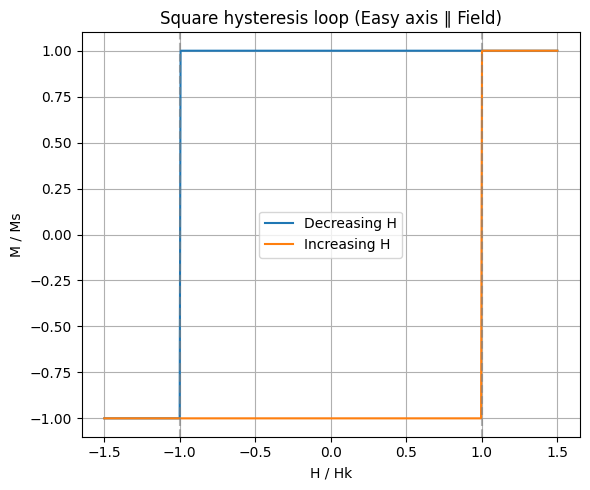

In [ ]:
# --- Plot ---
plt.figure(figsize=(6,5))
plt.plot(H_down/Hk, M_down/Ms, label="Decreasing H")
plt.plot(H_up/Hk, M_up/Ms, label="Increasing H")

plt.axvline(1, linestyle='--', color='gray', alpha=0.6)
plt.axvline(-1, linestyle='--', color='gray', alpha=0.6)

plt.xlabel("H / Hk")
plt.ylabel("M / Ms")
plt.title("Square hysteresis loop (Easy axis ∥ Field)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🔹 How does a perpendicular magnet respond to an in-plane field?
Let us now investigate the static behavior of a perpendicular-anisotropy free layer under an in-plane applied field. Studying this configuration allows us to observe how the magnetization tilts away from its easy axis and competes against the anisotropy energy. This provides deeper insight into the energy landscape, the balance between anisotropy and Zeeman energy, and the stability limits of the perpendicular state.

Compared to the out-of-plane field case, the in-plane field configuration reveals how the magnetization continuously rotates rather than switching abruptly, offering a clearer understanding of the underlying energy minimization process.

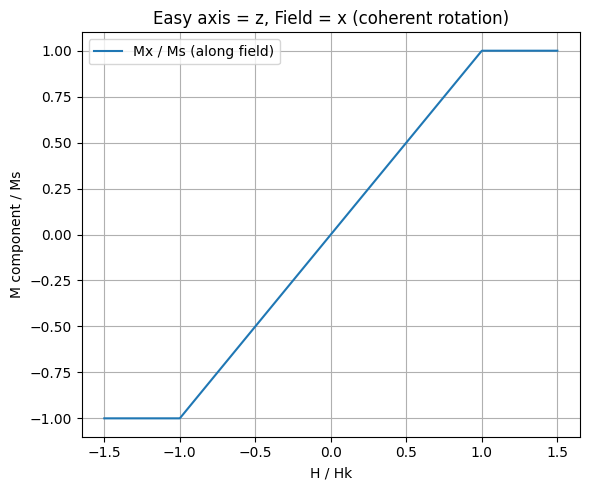

In [ ]:
# =========================================
# Easy axis = z, Field = x (clean version)
# =========================================

H_perp = np.linspace(-Hmax, Hmax, npts)
h = H_perp / Hk

# Clip for physical region
h_clip = np.clip(h, -1.0, 1.0)

# Magnetization components
Mx = Ms * h_clip
Mz = Ms * np.sqrt(1.0 - h_clip**2)

# For |H| > Hk → fully in-plane
Mz[np.abs(h) >= 1.0] = 0.0

# Plot
plt.figure(figsize=(6,5))
plt.plot(H_perp/Hk, Mx/Ms, label="Mx / Ms (along field)")
#plt.plot(H_perp/Hk, Mz/Ms, label="Mz / Ms (along easy axis)")

plt.xlabel("H / Hk")
plt.ylabel("M component / Ms")
plt.title("Easy axis = z, Field = x (coherent rotation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 🔹 How does an in-plane magnet respond to an out-of-plane field?
In-plane magnetic anisotropy was widely used in earlier generations of magnetic tunnel junction devices and remains important for understanding the evolution of MRAM technologies. In such systems, the magnetization naturally prefers to lie within the film plane due to shape anisotropy and material properties.

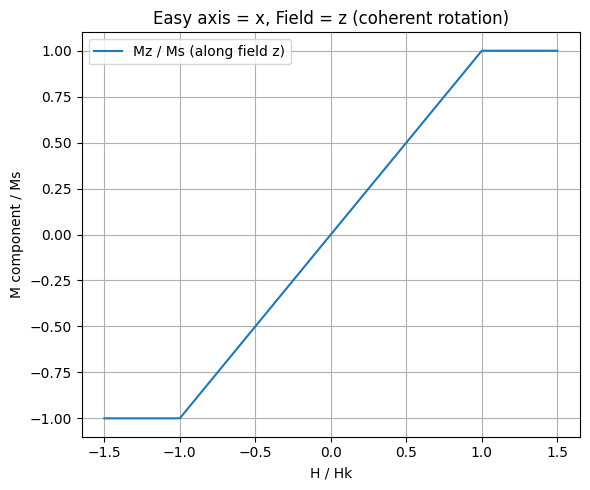

In [ ]:
# =========================================
# ADD-ON: Easy axis = x, Field = z (coherent rotation, no hysteresis)
# =========================================

H_perp = np.linspace(-Hmax, Hmax, npts)
h = H_perp / Hk
h_clip = np.clip(h, -1.0, 1.0)

# Along applied field (z): Mz = Ms * (H/Hk), saturates for |H|>=Hk
Mz = Ms * h_clip

# Along easy axis (x): Mx = Ms * sqrt(1 - (H/Hk)^2), goes to 0 for |H|>=Hk
Mx = Ms * np.sqrt(1.0 - h_clip**2)
Mx[np.abs(h) >= 1.0] = 0.0

plt.figure(figsize=(6,5))
plt.plot(H_perp/Hk, Mz/Ms, label="Mz / Ms (along field z)")
#plt.plot(H_perp/Hk, Mx/Ms, label="Mx / Ms (along easy axis x)")

plt.xlabel("H / Hk")
plt.ylabel("M component / Ms")
plt.title("Easy axis = x, Field = z (coherent rotation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 🔹 How does an in-plane magnet respond to an in-plane field?
Let us now investigate the static behavior of an in-plane anisotropy free layer under an in-plane applied magnetic field. In this configuration, the applied field is aligned with the easy axis, allowing us to directly observe hysteresis behavior and magnetization reversal within the plane. This study helps us understand coercivity, remanence, and the stability of the in-plane states under external perturbations, completing our comparison between different anisotropy–field configurations.

System evolution

In [ ]:
# =========================================
# ADD-ON: Easy axis = x, Field = x
# (square hysteresis loop)
# =========================================

# Mx is the switching component
Mx_down = np.ones_like(H_down) * Ms
Mx_up   = -np.ones_like(H_up) * Ms

Mx_down[H_down < -Hk] = -Ms
Mx_up[H_up > Hk] = Ms

Observable extraction (2 points)

In [ ]:
##################### YOUR CODE STARTS HERE #####################
# Observable extraction from hysteresis data (Easy axis = x, Field = x)

def _zero_crossing_x(x, y):
    """
    Return x where y crosses 0 using linear interpolation between the first
    sign-change pair found in the data order. Returns np.nan if no crossing.
    """
    y = np.asarray(y, dtype=float)
    x = np.asarray(x, dtype=float)

    idx0 = np.where(y == 0)[0]
    if idx0.size > 0:
        return float(x[idx0[0]])

    s = np.sign(y)
    s[s == 0] = 1
    idx = np.where(s[:-1] * s[1:] < 0)[0]
    if idx.size == 0:
        return np.nan

    k = int(idx[0])
    x0, x1 = x[k], x[k + 1]
    y0, y1 = y[k], y[k + 1]
    return float(x0 - y0 * (x1 - x0) / (y1 - y0))


def _value_at_H0(H, M):
    """Return M at H=0 by interpolation (or nearest if outside range)."""
    H = np.asarray(H, dtype=float)
    M = np.asarray(M, dtype=float)

    idx0 = np.where(H == 0)[0]
    if idx0.size > 0:
        return float(M[idx0[0]])

    if (H.min() > 0) or (H.max() < 0):
        return float(M[np.argmin(np.abs(H))])

    order = np.argsort(H)
    return float(np.interp(0.0, H[order], M[order]))


# 1) Coercive fields (where Mx crosses 0)
Hc_x_down = _zero_crossing_x(H_down, Mx_down)
Hc_x_up   = _zero_crossing_x(H_up,   Mx_up)

# 2) Remanent magnetization at H=0
Mr_x_down = _value_at_H0(H_down, Mx_down)
Mr_x_up   = _value_at_H0(H_up,   Mx_up)

# 3) Print clearly
print("Extracted hysteresis observables (Mx, Easy axis ∥ Field):")
print(f"  Hc_x (decreasing branch) = {Hc_x_down:.6g}")
print(f"  Hc_x (increasing branch) = {Hc_x_up:.6g}")
print(f"  Mr_x (decreasing branch) = {Mr_x_down:.6g}")
print(f"  Mr_x (increasing branch) = {Mr_x_up:.6g}")

# Optional: normalized outputs (only if Hk and Ms exist)
try:
    print("\nNormalized (using Hk and Ms):")
    print(f"  Hc_x_down / Hk = {Hc_x_down / Hk:.6g}")
    print(f"  Hc_x_up   / Hk = {Hc_x_up   / Hk:.6g}")
    print(f"  Mr_x_down / Ms = {Mr_x_down / Ms:.6g}")
    print(f"  Mr_x_up   / Ms = {Mr_x_up   / Ms:.6g}")
except NameError:
    pass

##################### YOUR CODE ENDS HERE #######################


Extracted hysteresis observables (Mx, Easy axis ∥ Field):
  Hc_x (decreasing branch) = -794180
  Hc_x (increasing branch) = 794180
  Mr_x (decreasing branch) = 1
  Mr_x (increasing branch) = -1

Normalized (using Hk and Ms):
  Hc_x_down / Hk = -0.997996
  Hc_x_up   / Hk = 0.997996
  Mr_x_down / Ms = 1
  Mr_x_up   / Ms = -1


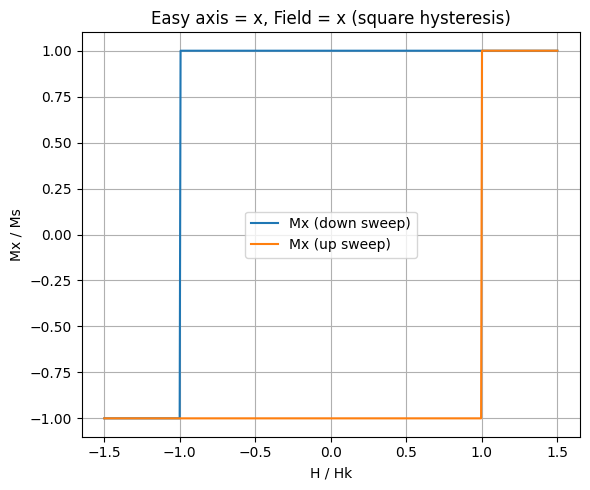

In [ ]:
# =========================================
# ADD-ON: Easy axis = x, Field = x
# (square hysteresis loop)
# =========================================

# Mx is the switching component
Mx_down = np.ones_like(H_down) * Ms
Mx_up   = -np.ones_like(H_up) * Ms

Mx_down[H_down < -Hk] = -Ms
Mx_up[H_up > Hk] = Ms

plt.figure(figsize=(6,5))
plt.plot(H_down/Hk, Mx_down/Ms, label="Mx (down sweep)")
plt.plot(H_up/Hk,   Mx_up/Ms,   label="Mx (up sweep)")

plt.xlabel("H / Hk")
plt.ylabel("Mx / Ms")
plt.title("Easy axis = x, Field = x (square hysteresis)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Simulation–Experiment Comparison

### Part 1 (3 points)
Compare your simulated in-plane and out-of-plane 𝑀−𝐻 loops with Fig. 2a and Fig. 2b in Ref. [1].

1. Identify which of your simulations corresponds to Fig. 2a (t=2.0 nm) vs Fig. 2b (t=1.3 nm), and justify your mapping using easy-axis direction.

2. Describe one key qualitative difference in loop shape (e.g., square vs rounded) and state one model assumption that could explain it.

### Part 2 (3 points)
In Ref. [1], the easy-axis direction changes around tCoFeB ≈ 1.5 nm. Using your energy-minimization model, explain why changing thickness can flip the preferred axis. Your explanation must reference the competition between:

* interfacial PMA contribution (scales like 1/𝑡) and

* demagnetization / shape anisotropy (favoring in-plane).

### Part 3 (3 points)
In Ref. [1], the coercive field for IMA (in-plane magnetic anisotropy) is larger than that for PMA (prependicular magnetic anisotropy). This is not the case for simultaion results. Use course material to explain. You would need to check model assumption in both code and course material.

# Question 2 (field-driven switching)
Let us now investigate the dynamic behavior of a single-domain magnet under an applied magnetic field.

While static energy minimization provides insight into equilibrium states and hysteresis behavior, real magnetic memory devices operate through dynamic switching processes. Understanding how the magnetization evolves in time under an external magnetic field is essential for determining switching reliability, speed, and stability.

In this section, we solve the Landau–Lifshitz–Gilbert (LLG) equation to study magnetization dynamics driven by an applied field. Our objective is to determine the critical switching field and to analyze how the switching speed depends on the magnitude of the applied magnetic field. This will allow us to connect the energy landscape studied in Question 1 with the time-dependent reversal process governed by magnetic damping and precession.

## Experiment runner (10 points)
This function automates a sweep over applied magnetic field values and runs the LLG-based free-layer dynamics for each field. Your task is to complete the observable extraction blocks so that, for each applied field, the function returns:

(1) final_state — whether switching occurred (1) or not (0), and

(2) switching_speed — the switching time (seconds) or np.nan if switching does not occur.

In [ ]:
def Field_switching_simulation(
    H_APP,
    V_pulse=0,
    t_pulse=0,
    V_base=0.0,
    NON=0,
    VNV=1,
    sim_end=25000,
):
    """
    VCMA pulsed switching simulation.

    Parameters
    ----------
    V_pulse : float
        MTJ voltage pulse amplitude (V). Common naming: V_MTJ or V_VCMA.
    t_pulse : float
        Pulse duration / pulse width (s). Common naming: t_pulse or tau_pulse.
    V_base : float
        Voltage applied outside the pulse window (V). Usually 0 V.
    NON, VNV : int
        Your existing model flags.
    sim_end : int
        End time index (in units of your discrete timestep).
    """

    # SOT current set by H_EX, as before
    I_SOT = 0

    sim_startup = 1
    time = np.arange(sim_startup-1, (sim_end+1))  # indices

    # Convert pulse duration to number of steps
    # Apply V_pulse from t=0 up to t_pulse (inclusive/exclusive depends on your convention)
    pulse_steps = int(np.round(t_pulse / t_step))
    pulse_end_idx = (sim_startup - 1) + pulse_steps  # last index where pulse may be active

    # --- Physical observables to be extracted ---
    # final_state: list of length len(H_APP)
    #   1 → successful switching occurred for that applied field
    #   0 → no switching occurred
    #
    # switching_speed: list of length len(H_APP)
    #   Switching time (in seconds) for each applied field.
    #   Use np.nan if switching does not occur.
    final_state = []
    switching_speed = []

    for H in H_APP:
      # Allocate arrays
      M_z = np.zeros(sim_end+1)
      Theta = np.zeros(sim_end+1)
      Phi = np.zeros(sim_end+1)
      R = np.zeros(sim_end+1)
      V = np.zeros(sim_end+1)

      PAP = 1
      R_MTJ, theta, mz, phi = init(PAP)
      R[0], Theta[0], M_z[0], Phi[0] = R_MTJ, theta, mz, phi

      # --- Observable extraction placeholders (provided) ---
      switched = False      # whether switching happened in this run
      t_switch = np.nan     # switching time (s), NaN if never switched
      threshold =  0.8      # switching criterion for mz (you must determine, 1 point)
      continue_flag = 1

      for i in trange(sim_startup-1, sim_end):
          ESTT, ESOT = 0, 0
          R_MTJ = R[i]

          # Pulse shaping: use V_pulse only during the pulse window
          V_now = V_pulse if i <= pulse_end_idx else V_base

          mz, phi_temp, theta_temp = switching(
              V_MTJ=V_now,
              I_SOT=I_SOT,
              R_MTJ=R_MTJ,
              theta=theta,
              phi=phi,
              ESTT=ESTT,
              ESOT=ESOT,
              H_APP=H,
              VNV=VNV,
              NON=NON,
              R_SOT_FL_DL=0,
          )

          phi, theta = phi_temp, theta_temp
          R_MTJ = tmr(V_now, mz)

          V[i] = V_now

          # next iteration
          M_z[i+1] = mz
          Theta[i+1] = theta
          Phi[i+1] = phi
          R[i+1] = R_MTJ
          ##################### YOUR CODE STARTS HERE #####################
          if mz > 0.8 and continue_flag == 1:
            switching_speed.append(i * t_step)
            switched = True
            continue_flag = 0
          ##################### YOUR CODE ENDS HERE #######################


      ##################### YOUR CODE STARTS HERE #####################
      if mz > threshold:
        final_state.append(1)
      else:
        final_state.append(0)

      if switched == 0:
        switching_speed.append(np.nan)
      ##################### YOUR CODE ENDS HERE #######################



    # # Plot
    # tick_spacing = 5e-9
    # plt.plot(time*t_step, M_z, label=f'V_pulse={V_pulse} V, t_pulse={t_pulse*1e9:.2f} ns')
    # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))
    # plt.xlabel('time(s)')
    # plt.ylabel('mz')
    # plt.tight_layout()
    # plt.grid()
    # plt.legend(loc='center right', title='H_EX = -50 Oe, \nI_SOT = -6.2619uA')
    # plt.get_current_fig_manager().set_window_title('paper_main_switch_with_VCMA_pulsed')
    # plt.show()

    return final_state, switching_speed



## Experiment (5 points)
In this experiment, we perform a sweep over different magnitudes of the applied magnetic field in order to determine the critical switching field and analyze the dependence of switching speed on field strength.

### Tasks

1. Run the simulation for the provided range of applied magnetic fields.
From the returned final_state and switching_speed, identify the smallest applied field that produces deterministic switching.

2. Refine the field sweep near the switching boundary to estimate the critical switching field with improved resolution. You need to report this value.

In [ ]:
H_APP = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 9e4, 10e4, 11e4, 12e4]
final_state, switching_speed = Field_switching_simulation(H_APP = H_APP)

100%|██████████| 25000/25000 [00:01<00:00, 15682.29it/s]


## Experiment result

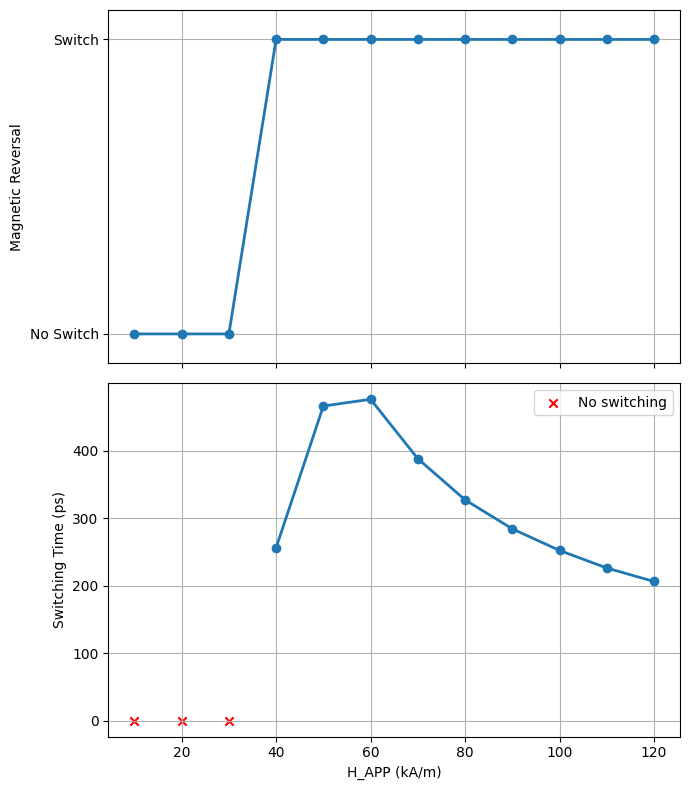

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure numpy arrays
H_APP = np.array(H_APP, dtype=float)
final_state = np.array(final_state, dtype=float)
switching_speed = np.array(switching_speed, dtype=float)

# ---- Display scaling ----
H_kA = H_APP / 1e3              # A/m → kA/m
t_ps = switching_speed * 1e12   # s → ps

fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# ---------------------------
# Subplot 1: Reversal vs Field
# ---------------------------
axes[0].plot(H_kA, final_state, 'o-', linewidth=2)
axes[0].set_ylabel("Magnetic Reversal")
axes[0].set_ylim(-0.1, 1.1)
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(["No Switch", "Switch"])
axes[0].grid(True)

# ---------------------------
# Subplot 2: Switching Time vs Field
# ---------------------------
valid = ~np.isnan(switching_speed)

axes[1].plot(H_kA[valid], t_ps[valid], 'o-', linewidth=2)

# Mark no-switch cases
axes[1].scatter(H_kA[~valid],
                np.zeros_like(H_kA[~valid]),
                marker='x',
                color='red',
                label='No switching')

axes[1].set_xlabel("H_APP (kA/m)")
axes[1].set_ylabel("Switching Time (ps)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


## Tasks (5 points)

1. Describe how switching time changes with increasing field strength.

2. Explain the observed behavior using the torque terms in the LLG equation.
Specifically, discuss how the applied field influences the effective torque and the switching dynamics.

# Question 3 (STT-driven switching)
Let us now investigate the dynamic behavior of a single-domain magnet under spin-transfer torque (STT).

While magnetic-field-driven switching provides fundamental insight into magnetization dynamics, modern magnetic memory devices such as STT-MRAM rely on current-induced torques to achieve reversal without the need for external magnetic fields. Understanding how spin-polarized current influences magnetization dynamics is therefore essential for analyzing device efficiency, switching reliability, and power consumption.

In this section, we solve the Landau–Lifshitz–Gilbert (LLG) equation including spin-transfer torque terms to study current-driven magnetization dynamics. Our objective is to determine the critical switching current and to analyze how the switching speed depends on the magnitude of the applied current. This allows us to connect the underlying torque mechanism to the time-dependent reversal process and to understand the threshold behavior that governs STT-based memory operation.

## Experiment runner (10 points)

This function automates a sweep over applied current values and runs the LLG-based free-layer dynamics with spin-transfer torque (STT) for each current. Your task is to complete the observable extraction blocks so that, for each applied current, the function returns:

(1) final_state — whether switching occurred (1) or not (0), and

(2) switching_speed — the switching time (seconds) or np.nan if switching does not occur.

In [ ]:
def STT_simulation(
    I_pulse,
    t_pulse,
    H_APP=0,
    I_base=0.0,
    NON=0,
    VNV=0,
    sim_end=25000,
):
    """
    VCMA pulsed switching simulation.

    Parameters
    ----------
    V_pulse : float
        MTJ voltage pulse amplitude (V). Common naming: V_MTJ or V_VCMA.
    t_pulse : float
        Pulse duration / pulse width (s). Common naming: t_pulse or tau_pulse.
    V_base : float
        Voltage applied outside the pulse window (V). Usually 0 V.
    NON, VNV : int
        Your existing model flags.
    sim_end : int
        End time index (in units of your discrete timestep).
    """

    # SOT current set by H_EX, as before
    I_SOT = 0

    sim_startup = 1
    time = np.arange(sim_startup-1, (sim_end+1))  # indices

    # Convert pulse duration to number of steps
    # Apply V_pulse from t=0 up to t_pulse (inclusive/exclusive depends on your convention)
    pulse_steps = int(np.round(t_pulse / t_step))
    pulse_end_idx = (sim_startup - 1) + pulse_steps  # last index where pulse may be active


    # --- Physical observables to be extracted ---
    # final_state: list of length len(I_pulse)
    #   1 → successful switching occurred for that applied current
    #   0 → no switching occurred
    #
    # switching_speed: list of length len(I_pulse)
    #   Switching time (in seconds) for each applied current.
    #   Use np.nan if switching does not occur.
    final_state = []
    switching_speed = []


    for I in I_pulse:
      # Allocate arrays
      M_z = np.zeros(sim_end+1)
      Theta = np.zeros(sim_end+1)
      Phi = np.zeros(sim_end+1)
      R = np.zeros(sim_end+1)
      V = np.zeros(sim_end+1)

      PAP = 1
      R_MTJ, theta, mz, phi = init(PAP)
      R[0], Theta[0], M_z[0], Phi[0] = R_MTJ, theta, mz, phi

      # --- Observable extraction placeholders (provided) ---
      switched = False      # whether switching happened in this run
      t_switch = np.nan     # switching time (s), NaN if never switched
      threshold = 0.8          # switching criterion for mz (you must determine, 1 point)
      continue_flag = 1


      for i in trange(sim_startup-1, sim_end):
          ESTT, ESOT = 1, 0
          R_MTJ = R[i]

          # Pulse shaping: use V_pulse only during the pulse window
          I_now = I if i <= pulse_end_idx else I_base
          V_now = I_now * R_MTJ

          mz, phi_temp, theta_temp = switching(
              V_MTJ=V_now,
              I_SOT=I_SOT,
              R_MTJ=R_MTJ,
              theta=theta,
              phi=phi,
              ESTT=ESTT,
              ESOT=ESOT,
              H_APP=H_APP,
              VNV=VNV,
              NON=NON,
              R_SOT_FL_DL=0,
          )

          phi, theta = phi_temp, theta_temp
          R_MTJ = tmr(V_now, mz)

          V[i] = V_now

          # next iteration
          M_z[i+1] = mz
          Theta[i+1] = theta
          Phi[i+1] = phi
          R[i+1] = R_MTJ

          ##################### YOUR CODE STARTS HERE #####################
          # TODO: Detect the first time switching occurs and record t_switch.
          # Hint: use `threshold`, `switched`, `i`, and `t_step`.
          # Requirement: record ONLY the first switching time.
          if mz > 0.8 and continue_flag == 1:
            switching_speed.append(i * t_step)
            switched = 1
            continue_flag = 0
          ##################### YOUR CODE ENDS HERE #######################


      ##################### YOUR CODE STARTS HERE #####################
      # TODO: Convert `switched` and `t_switch` into:
      # - final_state entry (0/1)
      # - switching_speed entry (t_switch or NaN)
      if mz > threshold:
        final_state.append(1)
      else:
        final_state.append(0)

      if switched == 0:
        switching_speed.append(np.nan)
      ##################### YOUR CODE ENDS HERE #######################



    # # Plot
    # tick_spacing = 5e-9
    # plt.plot(time*t_step, M_z, label=f'I_pulse={I_pulse} V, t_pulse={t_pulse*1e9:.2f} ns')
    # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))
    # plt.xlabel('time(s)')
    # plt.ylabel('mz')
    # plt.tight_layout()
    # plt.grid()
    # plt.legend(loc='center right', title='H_EX = -50 Oe, \nI_SOT = -6.2619uA')
    # plt.get_current_fig_manager().set_window_title('paper_main_switch_with_VCMA_pulsed')
    # plt.show()

    return final_state, switching_speed



## Experiment (5 points)

In this experiment, we perform a sweep over different magnitudes of the applied current in order to determine the critical switching current and analyze the dependence of switching speed on current strength.

Tasks

1. Run the simulation for the provided range of applied current values.
From the returned final_state and switching_speed, identify the smallest applied current that produces deterministic switching.

2. Refine the current sweep near the switching boundary to estimate the critical switching current with improved resolution. You need to report this value.

In [ ]:
I_pulse = [i * 1e-6 for i in range(10, 201, 10)]
STT_final_state, STT_switching_speed = STT_simulation(I_pulse=I_pulse, t_pulse=5e-9)

100%|██████████| 25000/25000 [00:01<00:00, 13579.83it/s]


## Experiment result

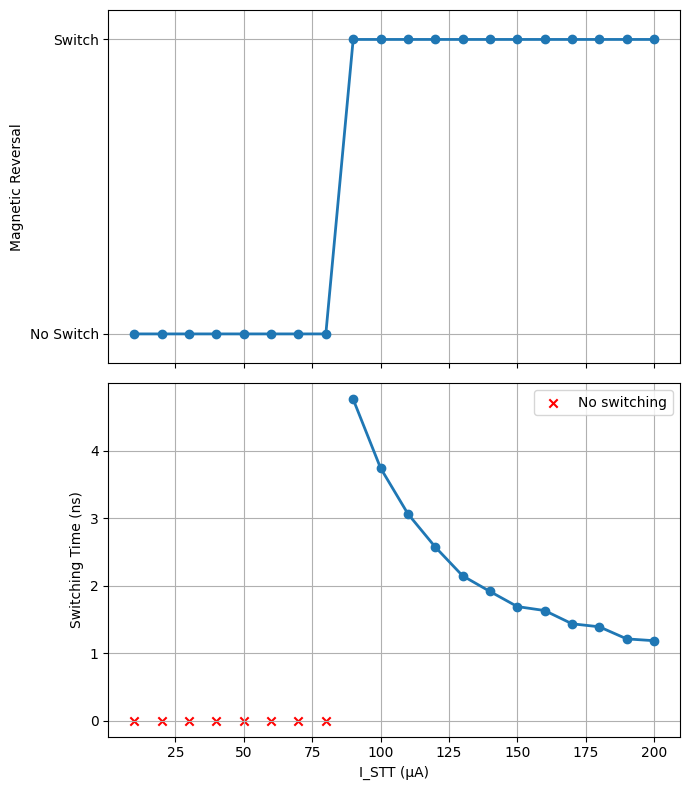

In [ ]:
# Ensure numpy arrays
I_pulse = np.array(I_pulse, dtype=float)
STT_final_state = np.array(STT_final_state, dtype=float)
STT_switching_speed = np.array(STT_switching_speed, dtype=float)

# Display scaling (A -> µA, s -> ns)
I_uA = I_pulse * 1e6
t_ns = STT_switching_speed * 1e9

fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# ---------------------------
# Subplot 1: Reversal vs Current
# ---------------------------
axes[0].plot(I_uA, STT_final_state, 'o-', linewidth=2)
axes[0].set_ylabel("Magnetic Reversal")
axes[0].set_ylim(-0.1, 1.1)
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(["No Switch", "Switch"])
axes[0].grid(True)

# ---------------------------
# Subplot 2: Switching Time vs Current
# ---------------------------
valid = ~np.isnan(STT_switching_speed)

axes[1].plot(I_uA[valid], t_ns[valid], 'o-', linewidth=2)

# Mark no-switch cases
axes[1].scatter(I_uA[~valid],
                np.zeros_like(I_uA[~valid]),
                marker='x',
                color='red',
                label='No switching')

axes[1].set_xlabel("I_STT (µA)")
axes[1].set_ylabel("Switching Time (ns)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

## Tasks (5 points)

1. Describe how switching time changes with increasing applied current.

2. Explain the observed behavior using the spin-transfer torque terms in the LLG equation. Specifically, discuss how the applied current modifies the torque balance and influences the switching dynamics.

## Simulation–Experiment Comparison

### Part 1 (3 points)
Refer to Ref [1] figure 5c.

1. After appropriate axis transformation, compare the functional dependence between current and switching time in simulation and experiment. Do they follow the same qualitative trend? Briefly explain.

2. Identify one quantitative discrepancy between simulation and experiment (e.g., slope, intercept, critical current scale).

3. Propose at least one physical or modeling assumption that could explain the discrepancy.

# Question 4
Let us now investigate the dynamic behavior of a single-domain magnet under voltage-controlled magnetic anisotropy (VCMA).

Unlike field-driven or current-driven switching, VCMA-based control modifies the magnetic anisotropy energy directly through an applied electric field across the tunnel barrier. This mechanism enables magnetization manipulation with potentially lower energy consumption, making it an attractive approach for next-generation low-power magnetic memory technologies.

In this section, we solve the Landau–Lifshitz–Gilbert (LLG) equation while incorporating the voltage-dependent anisotropy term. Our objective is to determine the critical voltage required for switching and to analyze how the switching speed and switching probability depend on both the voltage magnitude and pulse duration. This study allows us to understand how dynamically tuning the energy landscape can induce magnetization reversal and how pulse engineering influences deterministic versus probabilistic switching behavior.

## Experiment runner

This function automates a sweep over applied voltage values and runs the LLG-based free-layer dynamics with voltage-controlled magnetic anisotropy (VCMA) for each voltage.

In [ ]:
def VCMA_simulation(
    V_pulse,
    t_pulse,
    H_APP=0,
    V_base=0.0,
    NON=1,
    VNV=1,
    sim_end=25000,
    n_trials=5,   # <-- add this
):
    """
    VCMA pulsed switching simulation.

    Parameters
    ----------
    V_pulse : float
        MTJ voltage pulse amplitude (V). Common naming: V_MTJ or V_VCMA.
    t_pulse : float
        Pulse duration / pulse width (s). Common naming: t_pulse or tau_pulse.
    V_base : float
        Voltage applied outside the pulse window (V). Usually 0 V.
    NON, VNV : int
        Your existing model flags.
    sim_end : int
        End time index (in units of your discrete timestep).
    """

    # SOT current set by H_EX, as before
    I_SOT = 0

    sim_startup = 1
    time = np.arange(sim_startup-1, (sim_end+1))  # indices

    # Convert pulse duration to number of steps
    # Apply V_pulse from t=0 up to t_pulse (inclusive/exclusive depends on your convention)
    pulse_steps = int(np.round(t_pulse / t_step))
    pulse_end_idx = (sim_startup - 1) + pulse_steps  # last index where pulse may be active

    # --- Physical observables to be extracted ---
    # final_state: list of length len(V_pulse)
    #   1 → successful switching occurred for that applied voltage
    #   0 → no switching occurred
    #
    # switching_speed: list of length len(V_pulse)
    #   Switching time (in seconds) for each applied voltage.
    #   Use np.nan if switching does not occur.
    final_state = []
    switching_speed = []
    switching_probability_list = []


    for V_element in V_pulse:
      success_count = 0
      switching_times_this_voltage = []

      for trial in range(n_trials):

        # Allocate arrays
        M_z = np.zeros(sim_end+1)
        Theta = np.zeros(sim_end+1)
        Phi = np.zeros(sim_end+1)
        R = np.zeros(sim_end+1)
        V = np.zeros(sim_end+1)

        PAP = 1
        R_MTJ, theta, mz, phi = init(PAP)
        R[0], Theta[0], M_z[0], Phi[0] = R_MTJ, theta, mz, phi

        # --- Observable extraction placeholders (provided) ---
        switched = False      # whether switching happened in this run
        t_switch = np.nan     # switching time (s), NaN if never switched
        threshold = 0.8         # switching criterion for mz (you must determine, 1 point)
        continue_flag = 1

        for i in trange(sim_startup-1, sim_end):
            ESTT, ESOT = 0, 0
            R_MTJ = R[i]

            # Pulse shaping: use V_pulse only during the pulse window
            V_now = V_element if i <= pulse_end_idx else V_base

            mz, phi_temp, theta_temp = switching(
                V_MTJ=V_now,
                I_SOT=I_SOT,
                R_MTJ=R_MTJ,
                theta=theta,
                phi=phi,
                ESTT=ESTT,
                ESOT=ESOT,
                H_APP=H_APP,
                VNV=VNV,
                NON=NON,
                R_SOT_FL_DL=0,
            )

            phi, theta = phi_temp, theta_temp
            R_MTJ = tmr(V_now, mz)

            V[i] = V_now

            # next iteration
            M_z[i+1] = mz
            Theta[i+1] = theta
            Phi[i+1] = phi
            R[i+1] = R_MTJ

            if mz > threshold and continue_flag == 1:
              # switching_speed.append(i * t_step)
              t_switch = i * t_step
              switched = 1
              continue_flag = 0

        if switched:
          success_count += 1
          switching_times_this_voltage.append(t_switch)


      if len(switching_times_this_voltage) > 0:
          mean_t = np.mean(switching_times_this_voltage)
      else:
          mean_t = np.nan
      switching_probability = success_count / n_trials
      switching_probability_list.append(switching_probability)
      switching_speed.append(mean_t)


    # # Plot
    # tick_spacing = 5e-9
    # plt.plot(time*t_step, M_z, label=f'I_pulse={I_pulse} V, t_pulse={t_pulse*1e9:.2f} ns')
    # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))
    # plt.xlabel('time(s)')
    # plt.ylabel('mz')
    # plt.tight_layout()
    # plt.grid()
    # plt.legend(loc='center right', title='H_EX = -50 Oe, \nI_SOT = -6.2619uA')
    # plt.get_current_fig_manager().set_window_title('paper_main_switch_with_VCMA_pulsed')
    # plt.show()

    return switching_probability_list, switching_speed



## Experiment (5 points)

In this experiment, we perform a sweep over different voltage pulse magnitudes (and pulse durations) to determine the critical switching voltage and analyze how switching probability and mean switching time depend on both voltage magnitude and pulse width.

Tasks

1. Run the simulation for the provided range of voltage pulse values (with a fixed pulse duration).
From the returned switching_probability_list, identify the smallest pulse voltage at which switching becomes highly probable (e.g., probability ≈ 1). Clearly state your operational definition of the critical switching voltage in the stochastic regime.

2. Refine the voltage sweep near the transition region (where switching probability changes from near 0 to near 1) to estimate the critical switching voltage with improved resolution. You need to report this value and describe how switching probability and mean switching time behave near this boundary.

In [ ]:
V_pulse = [2.5, 2.6, 2.7, 2.8, 2.9, 3]
VCMA_switching_probability, VCMA_switching_speed = VCMA_simulation(V_pulse=V_pulse, t_pulse=5e-9)

100%|██████████| 25000/25000 [00:01<00:00, 15461.21it/s]


## Experiment Result

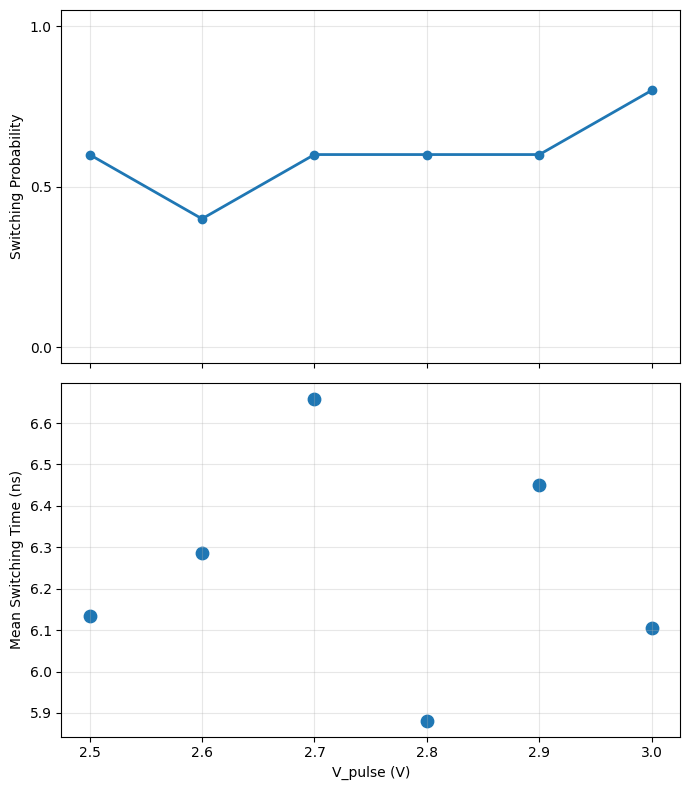

In [ ]:
V_pulse = np.array(V_pulse, dtype=float)
VCMA_switching_probability = np.array(VCMA_switching_probability, dtype=float)
VCMA_switching_speed = np.array(VCMA_switching_speed, dtype=float)

# Convert time to ns
t_ns = VCMA_switching_speed * 1e9

fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# ===========================
# Subplot 1: Switching Probability vs Voltage
# ===========================
axes[0].plot(V_pulse,
             VCMA_switching_probability,
             'o-',
             linewidth=2)

axes[0].set_ylabel("Switching Probability")
axes[0].set_ylim(-0.05, 1.05)
axes[0].set_yticks([0, 0.5, 1.0])
axes[0].grid(True, alpha=0.3)

# ===========================
# Subplot 2: Mean Switching Time vs Voltage
# ===========================
valid = ~np.isnan(VCMA_switching_speed)

axes[1].scatter(V_pulse[valid],
                t_ns[valid],
                s=80)

axes[1].set_xlabel("V_pulse (V)")
axes[1].set_ylabel("Mean Switching Time (ns)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Tasks (5 points)

1. Describe how switching probability and mean switching time change with increasing voltage pulse magnitude (for a fixed pulse duration).

2. Explain the observed behavior using the voltage-controlled magnetic anisotropy mechanism in the LLG framework. Specifically, discuss how the applied voltage modifies the effective anisotropy (and energy barrier) and how this influences switching probability and switching dynamics.